In [1]:
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.io as sio
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from __future__ import division
import random
import scipy
import h5py
import hdf5storage

In [3]:
## random seed will dictate the structure of the oracle network
sd=10000
np.random.seed(sd)

# wheretosave='/home/ubuntu/Notebooks/Circuit3A_Training_Data.h5'
wheretosave='/home/ubuntu/Notebooks/Circuit3B_Training_Data.h5'


## size of training and test sets
no_train=98000 
no_test=2000 
no_kernels = 3
no_bipolars = 10
no_amacrines = 5


In [4]:
## load stimulus images and separate into training and test sets

data = hdf5storage.loadmat('rand_stim_bigboy.h5')


imgs=data['imgset']

x_train = reshape(imgs[0:no_train, :, :], [no_train, 100, 100, 1])
x_test = reshape(imgs[no_train:no_train+no_test, :, :], [no_test, 100, 100, 1])

print(shape(x_train))
print(shape(x_test))

print(amax(x_train))
print(amin(x_train))

(98000, 100, 100, 1)
(2000, 100, 100, 1)
0.9999999291640758
-0.9999999206234627


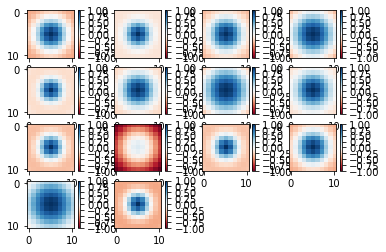

In [5]:

## create layer 1 convolutional kernels (difference of gaussians)

def difference_of_gaussians(ctr_sigma, surr_sigma, ctr_strength, surr_strength, x, y):
    
    center=0.4*(1/ctr_sigma)*exp(-0.5*square(sqrt(square(x)+square(y))/ctr_sigma))
    
    surround=0.4*(1/surr_sigma)*exp(-0.5*square(sqrt(square(x)+square(y))/surr_sigma))
    
    kernel = ctr_strength*center - surr_strength*surround
    
    maxk = amax(abs(kernel)) #normalization factor
    
    return kernel/maxk


x = np.linspace(-5, 5, 11)
y = np.linspace(-5, 5, 11)
xv, yv = np.meshgrid(x, y)

bipkernels = np.zeros([11, 11, 1, no_kernels])

kernel1 = difference_of_gaussians(3, 6, 13, 12.9, xv, yv) 
kernel2 = difference_of_gaussians(2, 8, 20, 13, xv, yv)
kernel3 = difference_of_gaussians(3, 8, 20, 20, xv, yv)
kernel4 = difference_of_gaussians(5, 6, 18, 18, xv, yv)
kernel5 = difference_of_gaussians(2, 4, 20, 14, xv, yv) 
kernel6 = difference_of_gaussians(3, 6, 20, 15, xv, yv)
kernel7 = difference_of_gaussians(5, 8, 19, 20, xv, yv)
kernel8 = difference_of_gaussians(3, 8, 22, 15, xv, yv)
kernel9 = difference_of_gaussians(2, 8, 15, 18, xv, yv)
kernel10 = difference_of_gaussians(5, 8, 13, 20, xv, yv)
kernel11 = difference_of_gaussians(2, 8, 13, 15, xv, yv)
kernel12 = difference_of_gaussians(3, 8, 20, 22, xv, yv)
kernel13 = difference_of_gaussians(5, 8, 20, 18, xv, yv)
kernel14 = difference_of_gaussians(2, 8, 13, 18, xv, yv)

bipkernels[:, :, 0, 0]=kernel1
bipkernels[:, :, 0, 1]=kernel4
bipkernels[:, :, 0, 2]=kernel5


plt.figure()
plt.subplot(4, 4, 1)
plt.imshow(kernel1, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 2)
plt.imshow(kernel2, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 3)
plt.imshow(kernel3, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 4)
plt.imshow(kernel4, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 5)
plt.imshow(kernel5, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 6)
plt.imshow(kernel6, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 7)
plt.imshow(kernel7, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 8)
plt.imshow(kernel8, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 9)
plt.imshow(kernel9, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 10)
plt.imshow(kernel10, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 11)
plt.imshow(kernel11, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 12)
plt.imshow(kernel12, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 13)
plt.imshow(kernel13, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 14)
plt.imshow(kernel14, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()




    




    

In [7]:
def bias_var(shape, initial_val):
    initial = tf.constant(initial_val, shape=shape)
    return tf.Variable(initial)

def bip_conv2d(x, W):
    padsize=10 
    paddedx=tf.pad(x, [[0, 0], [padsize, padsize], [padsize, padsize], [0, 0]], 'CONSTANT')
    outconv=tf.nn.conv2d(paddedx, W, strides=[1, 10, 10, 1], padding='SAME') #250 for movingdot and noise
    return outconv[:, 1:11, 1:11, :]

def synapse_var(shape, initial_val):
    initial=tf.constant(initial_val, shape=shape)
    return tf.Variable(initial)


In [8]:
## initialize all variables

bip_bias_init=array([-2.0, -3.0, -1.0]) 
bip_bias_init=bip_bias_init.astype(float32)
bipolar_bias = bias_var([no_kernels], bip_bias_init)

am_bias_init = -5.0 
am_bias = bias_var([1], am_bias_init)

gc_bias_init = 8.0 #0.0 #THIS SHOULD BE 8.0 FOR CIRCUIT 3A AND 0.0 FOR CIRCUIT 3B
gc_bias = bias_var([1, 1], gc_bias_init)

a=scipy.sparse.random(no_bipolars, no_bipolars*no_kernels, density=0.02).tocsr()
i_vec, j_vec = a.nonzero()
for i in i_vec:
    for j in j_vec:
        a[i,j] = 0.5*a[i,j] + 1.0

/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/ipykernel/__main__.py:17: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


In [9]:

bipam = 0.2 
bipgc = 0.8
amgc = 0.4


bip_am_syn_init = np.zeros([no_bipolars, no_bipolars, no_kernels, no_amacrines, no_amacrines])
bip_am_syn_init[2:4, 2:4, 1, 1, 1]=bipam
bip_am_syn_init[2:4, 4:6, 1, 1, 2]=bipam
bip_am_syn_init[4:6, 2:4, 1, 2, 1]=bipam
bip_am_syn_init[4:6, 4:6, 1, 2, 2]=bipam
bip_am_syn_init = bip_am_syn_init.astype(float32)
bip_am_syn = synapse_var([1, no_bipolars, no_bipolars, no_kernels, no_amacrines, no_amacrines], bip_am_syn_init)

bip_gc_syn_init = np.zeros([1, no_bipolars, no_bipolars, no_kernels])
bip_gc_syn_init[0, 3:5, 3:5, 0]=bipgc
bip_gc_syn_init=bip_gc_syn_init.astype(float32)
bip_gc_syn = synapse_var([1, no_bipolars, no_bipolars, no_kernels],bip_gc_syn_init)

am_gc_syn_init = np.zeros([1, no_amacrines, no_amacrines])
am_gc_syn_init[0, 1:3, 1:3]=amgc
am_gc_syn_init = am_gc_syn_init.astype(float32)
am_gc_syn = synapse_var([1, no_amacrines, no_amacrines], am_gc_syn_init)


In [10]:
## graph structure

stimulus_ = tf.placeholder("float32", name="stim_placeholder")

bipolar_cell_layer = tf.nn.relu(tf.nn.bias_add(bip_conv2d(stimulus_, bipkernels), bipolar_bias))


biplyr = tf.reshape(bipolar_cell_layer, [-1, no_bipolars*no_bipolars*no_kernels, 1])

tilebip_am_syn=tf.tile(tf.transpose(tf.reshape(bip_am_syn, [1, no_bipolars*no_bipolars*no_kernels, no_amacrines*no_amacrines]), [0, 2, 1]), [1, 1, 1])


amacrine_activation = 3.0*tf.reshape(tf.linalg.matmul(tilebip_am_syn, biplyr), [-1,no_amacrines, no_amacrines])

amacrine_cell_layer = tf.nn.relu(tf.add(amacrine_activation, am_bias))


gc_activation = tf.multiply(bip_gc_syn, bipolar_cell_layer) 

gc_activation_inhib = tf.multiply(am_gc_syn, amacrine_cell_layer) 

gc_output = tf.nn.relu(tf.add_n([tf.reduce_sum(gc_activation, [1, 2, 3]), -1.0*tf.reduce_sum(gc_activation_inhib, [1, 2])])+gc_bias)




In [13]:
## run the graph forward and save training data

sess=tf.Session()
sess.run(tf.global_variables_initializer())
    

train_fd={stimulus_: x_train}
test_fd={stimulus_: x_test}

bip_output = bipolar_cell_layer.eval(session=sess, feed_dict=test_fd)
am_output = amacrine_cell_layer.eval(session=sess, feed_dict=test_fd)
y_test=gc_output.eval(session=sess, feed_dict=test_fd)


y_train = zeros([1, 98000])
for i in range(10):
    y_train[0, i*9800:(i+1)*9800]=gc_output.eval(session=sess, feed_dict={stimulus_: x_train[i*9800:(i+1)*9800, :, :, :]})

In [14]:
db = {}

db[u'bipolar_bias'] = bipolar_bias.eval(session=sess)
db[u'bip_gc_syn'] = bip_gc_syn.eval(session=sess)
db[u'am_gc_syn'] = am_gc_syn.eval(session=sess)
db[u'bip_am_syn'] = bip_am_syn.eval(session=sess)
db[u'gc_bias'] = gc_bias.eval(session=sess)
db[u'am_bias'] = am_bias.eval(session=sess)

db[u'bip_output'] = bip_output
db[u'am_output'] = am_output

db[u'bipkernels'] = bipkernels
db[u'randomseed'] = sd

db[u'x_train'] = x_train
db[u'x_test'] = x_test

db[u'y_train'] = y_train
db[u'y_test'] = y_test

hdf5storage.savemat(wheretosave, db)

(2000, 10, 10, 3)
(1, 2000)
(2000, 10, 10, 3)


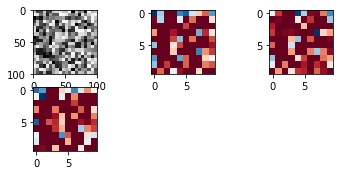

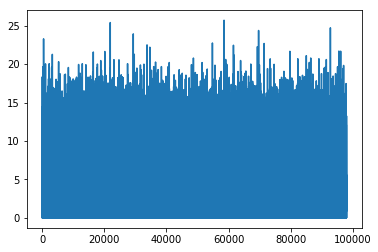

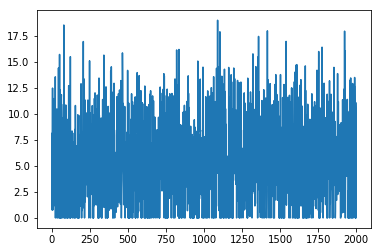

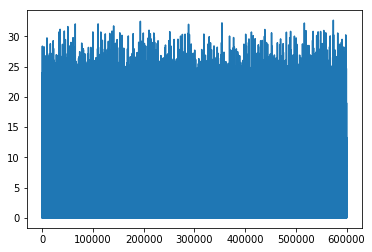

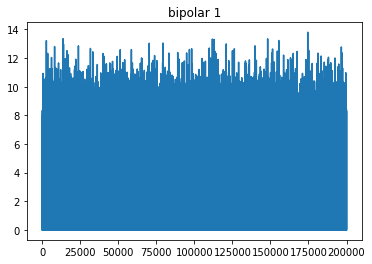

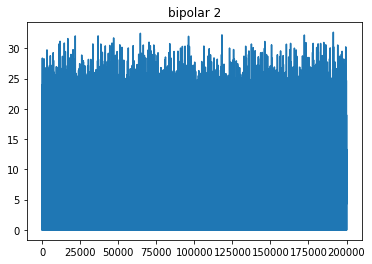

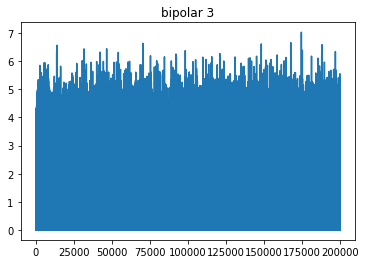

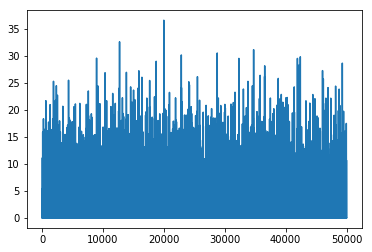

In [15]:
## some visualizations for debugging purposes

fd={stimulus_: x_test}
biplayertest=bipolar_cell_layer.eval(session=sess, feed_dict=fd)
amlayertest = amacrine_cell_layer.eval(session=sess, feed_dict=fd)
gcact=gc_activation.eval(session=sess, feed_dict=fd)

print(shape(biplayertest))
print(shape(y_test))
print(shape(gcact))

plt.figure()
plt.subplot(3, 3, 1)
plt.imshow(x_test[1, :, :, 0], cmap=plt.get_cmap('gray'))

for i in range(no_kernels):
    plt.subplot(3, 3, i+2)
    plt.imshow(biplayertest[1, :, :, i], cmap=plt.get_cmap('RdBu'))
#     plt.clim(0, 4000)
    
plt.figure()
plt.plot(squeeze(y_train))

plt.figure()
plt.plot(squeeze(y_test))

plt.figure()
plt.plot(reshape(squeeze(biplayertest), [300*2000, 1]))

plt.figure()
plt.plot(reshape(squeeze(biplayertest[:, :, :, 0]), [100*2000, 1]))
plt.title('bipolar 1')
plt.figure()
plt.plot(reshape(squeeze(biplayertest[:, :, :, 1]), [100*2000, 1]))
plt.title('bipolar 2')
plt.figure()
plt.plot(reshape(squeeze(biplayertest[:, :, :,2]), [100*2000, 1]))
plt.title('bipolar 3')


plt.figure()
plt.plot(reshape(squeeze(amlayertest), [25*2000, 1]))





0.2
0.4
(1, 5, 5)
(1, 10, 10, 3)
(1, 5, 5)


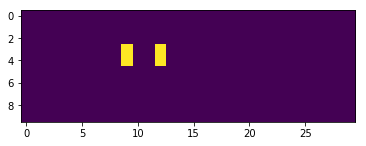

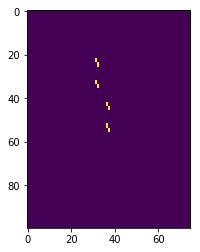

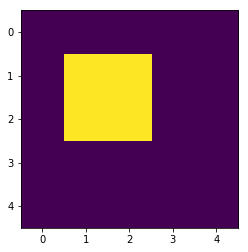

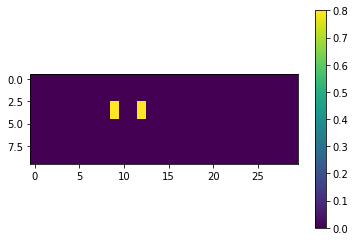

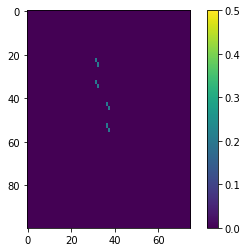

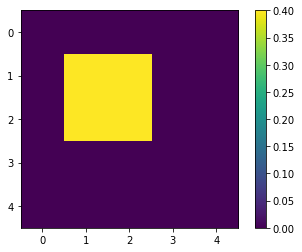

In [16]:
print(amax(bip_am_syn_init))
print(amax(am_gc_syn_init))
plt.figure()
plt.imshow(reshape(bip_gc_syn.eval(session=sess), [no_bipolars, no_kernels*no_bipolars]))

plt.figure()
plt.imshow(reshape(bip_am_syn.eval(session=sess), [no_bipolars*no_bipolars, no_kernels*no_amacrines*no_amacrines]))

plt.figure()
plt.imshow(squeeze(am_gc_syn.eval(session=sess)))
print(shape(am_gc_syn.eval(session=sess)))

print(shape(bip_gc_syn.eval(session=sess)))
plt.figure()
plt.imshow(reshape(bip_gc_syn.eval(session=sess), [10, 30]))
plt.colorbar()

plt.figure()
plt.imshow(reshape(bip_am_syn.eval(session=sess), [no_bipolars*no_bipolars, no_kernels*no_amacrines*no_amacrines]))
plt.colorbar()
plt.clim([0.0, 0.5])

plt.figure()
plt.imshow(squeeze(am_gc_syn.eval(session=sess)))
print(shape(am_gc_syn.eval(session=sess)))
plt.colorbar()